In [1]:
#download data of bitmap images
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/hand.npy

--2021-05-05 07:34:41--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/hand.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.202.128, 74.125.193.128, 2a00:1450:400b:c01::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228750112 (218M) [application/octet-stream]
Saving to: ‘hand.npy’

hand.npy            100%[===================>] 218.15M  55.3MB/s    in 3.9s    

2021-05-05 07:34:45 (55.3 MB/s) - ‘hand.npy’ saved [228750112/228750112]



In [1]:
#import modules
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# import tensorflow as tf
import pickle as pkl

import time

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
data =  np.load('hand.npy') #input is the file location stored as npy

In [4]:
data.shape

(291773, 784)

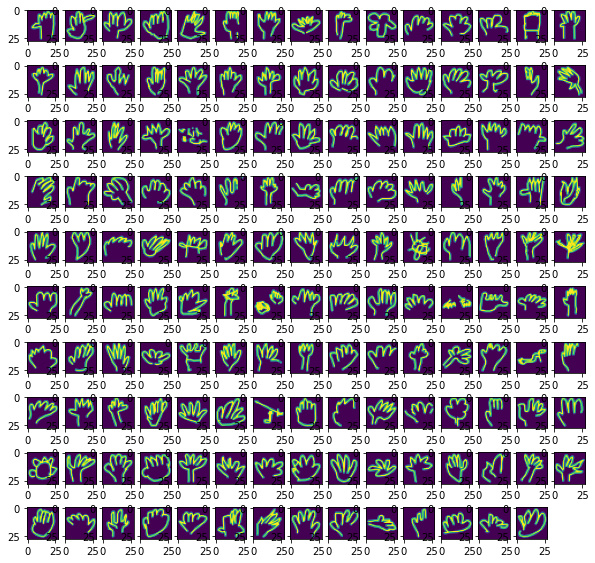

In [5]:
#plot sample images 

fig=plt.figure(figsize=(10, 10))
columns = 15
rows = 10
for i in range(1, columns*rows):
    img = data[i+44].reshape((28,28))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [6]:
def model_inputs(real_dims, z_dims):
    '''
    real_dims : df dimensions
    z_dims : placeholder dimensions
    return input dims, input placeholder dims
    '''
    inputs_real = tf.placeholder(tf.float32, shape=(None, real_dims), name='input_real')
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dims), name='input_z')

    return inputs_real, inputs_z

In [7]:
def get_data(path):
        try:
            data = np.load(path)

            Y = []
            for i in trange(data.shape[0]):
                Y.append([1,0])
            Y = np.array(Y)

            (x_train, y_train, x_test, y_test) = train_test_split(data, Y)
            x_train = (x_train.astype(np.float32)) / 255
            x_train = x_train.reshape(x_train.shape[0], 784)

            return (x_train, y_train, x_test, y_test)  

        except Exception as e:
            print (e)

In [8]:
x_train, y_train, x_test, y_test = get_data('hand.npy')

100%|██████████| 291773/291773 [00:00<00:00, 412736.88it/s]


In [9]:
x_train.shape

(218829, 784)

In [10]:
def generator(z, out_dims, n_units=128, reuse=False, alpha=0.01):
  with tf.variable_scope('generator', reuse=reuse):
    
    #hidden layer
    h1 = tf.layers.dense(z,n_units, activation=None,)
    
    #leaky relu implementation
    h1 = tf.maximum(alpha*h1, h1)
    
    #tanh 
    logits = tf.layers.dense(h1, out_dims)
    
    out = tf.tanh(logits)
    
    return out

In [11]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
  with tf.variable_scope('discriminator', reuse=reuse):
    
    #hidden layer
    h1 = tf.layers.dense(x, n_units, activation=None)
    #leaky_relu
    h1 = tf.maximum(alpha*h1, h1)
    
    #sigmoid
    logits = tf.layers.dense(h1, 1, activation=None)
    out = tf.sigmoid(logits)
    
    return out, logits

In [12]:
#hyperparams

r_size = 784
z_size = 100
g_units = 128
d_units = 128

alpha = 0.01

smooth = 0.1

In [13]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

inputs_real, inputs_z = model_inputs(r_size, z_size)

In [14]:
g_out = generator(inputs_z, r_size, g_units)

/opt/python/envs/default/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/opt/python/envs/default/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [15]:

d_out_real, real_logit = discriminator(inputs_real,)
d_out_fake, fake_logits = discriminator(g_out, reuse=True)

In [16]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logit, labels=tf.ones_like(real_logit)*(1-smooth)))

In [17]:
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake_logits)))

In [18]:
d_loss = d_loss_fake+d_loss_real

In [19]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake_logits)))

In [20]:
lr = 0.002

In [21]:
tvar = tf.trainable_variables()

In [22]:
gvar = [var for var in tvar if var.name.startswith('generator')]

In [23]:
dvar = [var for var in tvar if var.name.startswith('discriminator')]

In [24]:
d_opt = tf.train.AdamOptimizer(learning_rate=lr).minimize(d_loss, var_list=dvar)
g_opt = tf.train.AdamOptimizer(lr).minimize(g_loss,var_list=gvar)

In [26]:
start = time.time()
batch_size = 100000
epochs = 100
samples = []
losses = []
# Only save generator variables
saver = tf.train.Saver(var_list=gvar)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(x_train.shape[0]//batch_size):
            batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            
            batch_images = batch*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
            _ = sess.run(g_opt, feed_dict={inputs_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {inputs_z: batch_z, inputs_real: batch_images})
        train_loss_g = g_loss.eval({inputs_z: batch_z})
        if e%10 == 0:    
          print("Epoch {}/{}...".format(e, epochs),
                "Discriminator Loss: {:.4f}...".format(train_loss_d),
                "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(inputs_z, r_size, n_units=g_units, reuse=True, alpha=alpha),
                       feed_dict={inputs_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

end = time.time()
print('Time elapsed : ', (end-start)/60, ' mins.')

Epoch 0/100... Discriminator Loss: 2.7301... Generator Loss: 0.1792
Epoch 10/100... Discriminator Loss: 0.9457... Generator Loss: 0.9203
Epoch 20/100... Discriminator Loss: 0.5080... Generator Loss: 2.1614
Epoch 30/100... Discriminator Loss: 0.4331... Generator Loss: 2.6622
Epoch 40/100... Discriminator Loss: 0.3530... Generator Loss: 5.3604
Epoch 50/100... Discriminator Loss: 0.4300... Generator Loss: 2.6798
Epoch 60/100... Discriminator Loss: 0.5411... Generator Loss: 1.6894
Epoch 70/100... Discriminator Loss: 0.4418... Generator Loss: 2.2896
Epoch 80/100... Discriminator Loss: 0.7550... Generator Loss: 1.1512
Epoch 90/100... Discriminator Loss: 0.4806... Generator Loss: 2.1157
Time elapsed :  3.9523708542188007  mins.


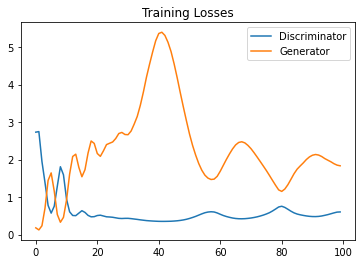

In [27]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

In [28]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(5,5), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys')
    
    return fig, axes

In [29]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [1]:
_ = view_samples(80, samples)

NameError: NameError: name 'view_samples' is not defined

In [0]:
rows, cols = 10, 10
fig, axes = plt.subplots(figsize=(8,6), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)